In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

from analysis import *

import sys
sys.path.insert(0, '../') 
from dl_spectral_normalization.models import alexnet as model
from get_cifar10 import get_cifar10_dataset

%matplotlib inline

In [3]:
Xtr, Ytr, Xtt, Ytt = get_cifar10_dataset(0, n_samps=50000)
_, Ytr_rand, _, Ytt_rand = get_cifar10_dataset(100, n_samps=50000)
val_set = {'X': Xtt[:500], 'Y': Ytt[:500]}
Xtt, Ytt = Xtt[500:], Ytt[500:]
beta_list = np.array([np.inf, 1.0, 1.3, 1.6, 2.0, 4.0])
arch = model.alexnet_sn
C2 = np.mean([np.sqrt(np.sum(np.square(i))) for i in Xtr])
gamma = 0.002*C2
eps_wrm = 1./(2*gamma)
eps = 0.05*C2

# Distribution of magnitude of gradients

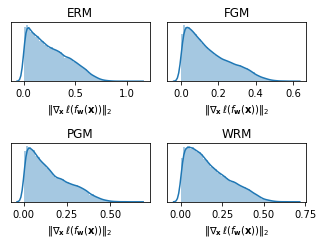

In [4]:
beta_ignore = [1.0, 1.6, 2.0, 4.0, np.inf]
xlabel=r'$\Vert\nabla_{\mathbf{x}}\, \ell(f_{\mathbf{w}}(\mathbf{x}))\Vert_2$'

plt.figure(figsize=(4.5, 3.5))
dirname = '/data/save_weights_tf1.10.1/cifar10/alexnet/'
defense = 'erm'
resultsfile = '/data/save_weights_tf1.10.1/results/kappahist_results_cifar10_alexnet_%s'%(defense)
kappa_plots = make_kappa_plots(Xtr, Ytr, beta_list, dirname, defense, resultsfile, arch, plot_stuff=False)
for k in beta_ignore:
    if k in kappa_plots: kappa_plots.pop(k)
plt.subplot(2, 2, 1)
plot_hists(kappa_plots, value_name=xlabel, legend=False)
plt.title('ERM')
plt.yticks([])

defense = 'fgm'
resultsfile = '/data/save_weights_tf1.10.1/results/kappahist_results_cifar10_alexnet_%s'%(defense)
kappa_plots = make_kappa_plots(Xtr, Ytr, beta_list, dirname, defense, resultsfile, arch, plot_stuff=False)
for k in beta_ignore:
    if k in kappa_plots: kappa_plots.pop(k)
plt.subplot(2, 2, 2)
plot_hists(kappa_plots, value_name=xlabel, legend=False)
plt.title('FGM')
plt.yticks([])

defense = 'pgm'
resultsfile = '/data/save_weights_tf1.10.1/results/kappahist_results_cifar10_alexnet_%s'%(defense)
kappa_plots = make_kappa_plots(Xtr, Ytr, beta_list, dirname, defense, resultsfile, arch, plot_stuff=False)
for k in beta_ignore:
    if k in kappa_plots: kappa_plots.pop(k)
plt.subplot(2, 2, 3)
plot_hists(kappa_plots, value_name=xlabel, legend=False)
plt.title('PGM')
plt.yticks([])

defense = 'wrm'
resultsfile = '/data/save_weights_tf1.10.1/results/kappahist_results_cifar10_alexnet_%s'%(defense)
kappa_plots = make_kappa_plots(Xtr, Ytr, beta_list, dirname, defense, resultsfile, arch, plot_stuff=False)
for k in beta_ignore:
    if k in kappa_plots: kappa_plots.pop(k)
plt.subplot(2, 2, 4)
plot_hists(kappa_plots, value_name=xlabel, legend=False)
plt.title('WRM')
plt.yticks([])

plt.tight_layout()
plt.savefig('/data/Figures/cifar10_alexnet_kappadist.pdf', format='pdf', dpi=500, bbox_inches='tight')
plt.show()

# Distribution of norm gains

INFO:tensorflow:Restoring parameters from /data/save_weights_tf1.10.1/cifar10/alexnet/erm_betainf/checkpoints/epoch46
INFO:tensorflow:Restoring parameters from /data/save_weights_tf1.10.1/cifar10/alexnet/erm_beta1.0/checkpoints/epoch200
INFO:tensorflow:Restoring parameters from /data/save_weights_tf1.10.1/cifar10/alexnet/erm_beta1.3/checkpoints/epoch200
INFO:tensorflow:Restoring parameters from /data/save_weights_tf1.10.1/cifar10/alexnet/erm_beta1.6/checkpoints/epoch200
INFO:tensorflow:Restoring parameters from /data/save_weights_tf1.10.1/cifar10/alexnet/erm_beta2.0/checkpoints/epoch46
INFO:tensorflow:Restoring parameters from /data/save_weights_tf1.10.1/cifar10/alexnet/erm_beta4.0/checkpoints/epoch19


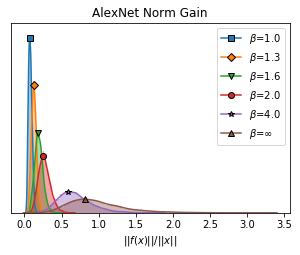

In [5]:
def compute_output_input_norm_ratios(X, save_dir, arch, beta=1.0):
    input_norms = np.sqrt(np.sum(np.square(X), axis=(1, 2, 3)))
    output_norms = np.linalg.norm(dl_utils.get_embedding(X, save_dir, arch, 
                                                         beta=beta, num_channels=X.shape[-1]),
                                  axis=1)
    return output_norms/input_norms

plt.figure(figsize=(5, 3.5))

resultsfile = '/data/save_weights_tf1.10.1/results/normratios_results_cifar10_alexnet_erm_redo.pickle'
if os.path.isfile(resultsfile):
    ratios = pickle.load(file(resultsfile, 'rb'))
else:
    ratios = {}    
for beta in beta_list:
    if beta not in ratios:
        save_dir = os.path.join(dirname, 'erm_beta%s'%(beta))
        ratios[beta] = compute_output_input_norm_ratios(Xtt, save_dir, arch, beta=beta)
        pickle.dump(ratios, file(resultsfile, 'wb'))

ratios[r'$\infty$'] = ratios.pop(np.inf)

plot_hists(ratios, value_name=r'$||f(x)||/||x||$', add_markers=True)
plt.yticks([])
plt.title('AlexNet Norm Gain')
plt.savefig('/data/Figures/cifar10_alexnet_normgain.pdf', format='pdf', dpi=500, bbox_inches='tight')
plt.show()